In [ ]:
#import all necessary modules
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import optimizers
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
#define height and width of the image
height=300
width=300

#create a ResNet50 model instance without the top layer as we will add our own top layer
base_model=ResNet50(weights='imagenet',include_top=False,input_shape=(height,width,3))

In [ ]:
#define directory containing training and validation data
train_dir=r'C:\Users\srish\OneDrive\Desktop\Project final\currency_2\train'
validation_dir=r'C:\Users\srish\OneDrive\Desktop\Project final\currency_2\val'

#number of batches the data has to be divided into
batch_size=32

#create datagen and generator to load the data from training directory
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,rotation_range=90,horizontal_flip=True,vertical_flip=True,width_shift_range=0.2,
    height_shift_range=0.2,shear_range=0.2,zoom_range=0.2)
train_generator=train_datagen.flow_from_directory(train_dir,target_size=(height,width),batch_size=batch_size)

#create datagen and generator to load the data from validation directory
validation_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,rotation_range=90,horizontal_flip=True,vertical_flip=True)
validation_generator=validation_datagen.flow_from_directory(validation_dir,target_size=(height,width),batch_size=batch_size)

In [ ]:
#our own model which will be added onto the ResNet50 model
def build_finetune_model(base_model,dropout,fc_layers,num_classes):
    for layer in base_model.layers:
        layer.trainable=False

    x=base_model.output
    x=Flatten()(x)
    for fc in fc_layers:
        x=Dense(fc,activation='relu')(x)
        x=Dropout(dropout)(x)

    predictions=Dense(num_classes,activation='softmax')(x)

    finetune_model=Model(inputs=base_model.input,outputs=predictions)

    return finetune_model

class_list=['Real','Fake'] #the labels of our data
FC_Layers=[1024,1024]
dropout=0.7

finetune_model=build_finetune_model(base_model,dropout=dropout,fc_layers=FC_Layers,num_classes=len(class_list))

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Define the number of training and validation images
num_train_images = 1442
num_validation_images = 412

# Define batch size and number of epochs
batch_size = 32
num_epochs = 50

# Define ModelCheckpoint callback
checkpoint = ModelCheckpoint("Final_model.keras",
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             save_freq='epoch')

# Define EarlyStopping callback
early = EarlyStopping(monitor='val_accuracy',
                      min_delta=0,
                      patience=40,
                      verbose=1,
                      mode="max")

# Define optimizer
optimizer = Adam(learning_rate=0.00001)

# Compile the model with the new optimizer
finetune_model.compile(loss="categorical_crossentropy",
                       optimizer=optimizer,
                       metrics=['accuracy'])

# Compute validation steps
validation_steps = num_validation_images // batch_size

# Train the model using fit
history = finetune_model.fit(x=train_generator,
                             steps_per_epoch=num_train_images // batch_size,
                             epochs=num_epochs,
                             validation_data=validation_generator,
                             validation_steps=validation_steps,
                             callbacks=[checkpoint, early])

# Save the model weights
finetune_model.save_weights("Final_model.weights.h5")


# Testing

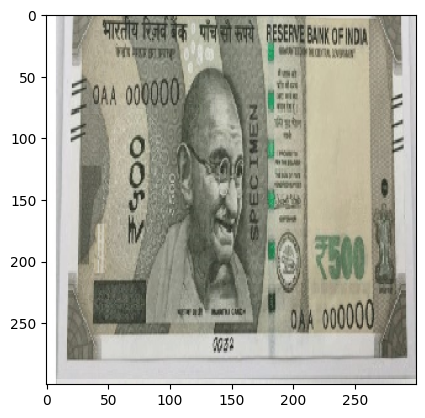

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Fake


In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

# Testing the model
img_path = r'C:\Users\srish\OneDrive\Desktop\Project final\currency\Fake\F5 (2).JPEG'  # The path of the testing image, the pic taken from the phone should come here
img = load_img(img_path, target_size=(300, 300))
img = img_to_array(img)
plt.imshow(img.astype('uint8'))  # Display the image
plt.show()
img = np.expand_dims(img, axis=0)

finetune_model.load_weights("Final_model.weights.h5")  # Load the model weights

output = finetune_model.predict(img)  # Predicting the image using model created
if output[0][0] > output[0][1]:  # Comparison
    print("Fake")
else:
    print("Real")



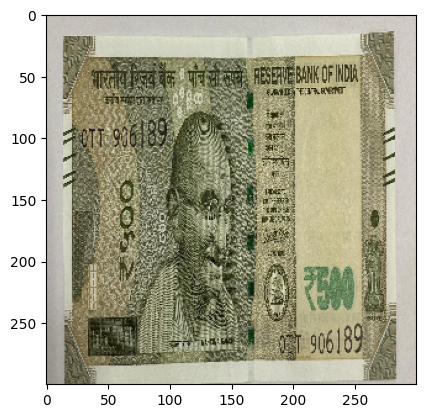

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
Real


In [ ]:


from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

# Testing the model
img_path = r'C:\Users\srish\OneDrive\Desktop\Project final\currency\Real\R5.jpeg'  # The path of the testing image, the pic taken from the phone should come here
img = load_img(img_path, target_size=(300, 300))
img = img_to_array(img)
plt.imshow(img.astype('uint8'))  # Display the image
plt.show()
img = np.expand_dims(img, axis=0)

finetune_model.load_weights("Final_model.weights.h5")  # Load the model weights

output = finetune_model.predict(img)  # Predicting the image using model created
if output[0][0] > output[0][1]:  # Comparison
    print("Fake")
else:
    print("Real")



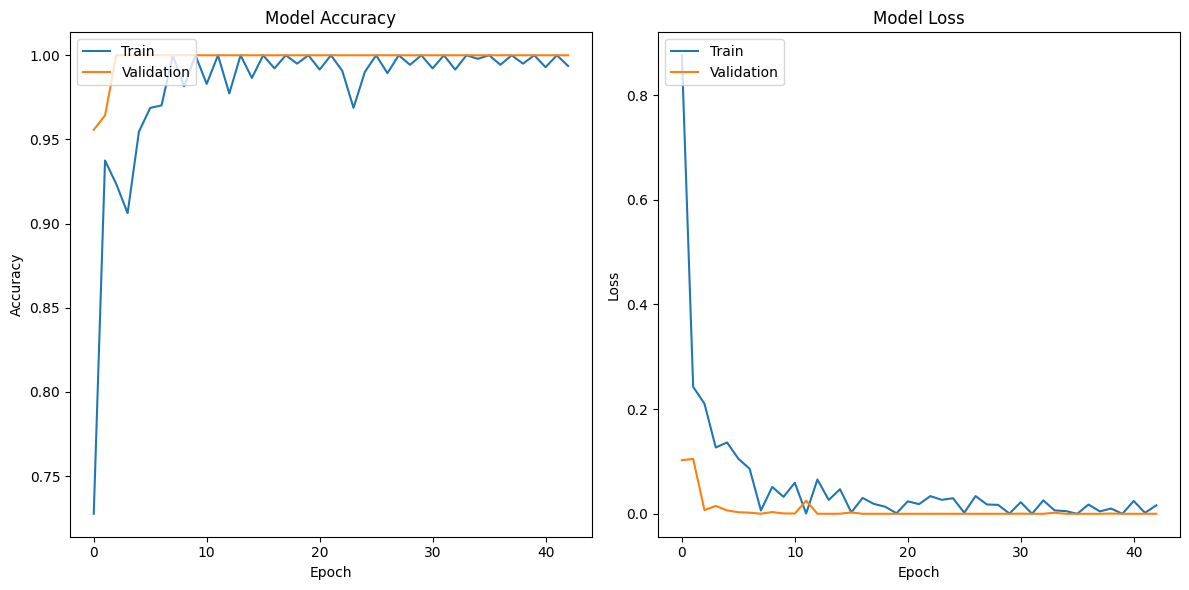

In [ ]:
# Plotting the training history (accuracy and loss over epochs)
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
# Get the final training accuracy
train_accuracy = history.history['accuracy'][-1]

# Get the final validation accuracy
val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")


Final Training Accuracy: 0.9936
Final Validation Accuracy: 1.0000
